In [2]:
from numpy.random import seed
seed(1)

%load_ext autoreload
%autoreload 2

from PatientSet import *
from Constants import Constants
import Metrics
from analysis import *
from copy import copy

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import QuantileTransformer

from Classifiers import *
from Clustering import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import seaborn as sns
from pylab import rcParams

def layout_figure(linewidth = 1, width = 10, 
                  height = 10, context = 'paper', 
                  fontsize = 2, palette = 'colorblind'):
    rc = {'lines.linewidth': linewidth}
    rcParams['figure.figsize'] = width, height
    sns.set_context(context, font_scale = fontsize, rc = rc)
    sns.color_palette(palette, 8)
    
layout_figure()

In [22]:
db = load_patientset()
default_clusterer = lambda : FClusterer(5, dist_func = l2)

In [23]:
patient_info = pd.read_csv('data/patient_info.csv', index_col = 0).sort_index()
patient_info = patient_info.loc[db.ids,:]
patient_info.head()

,ROI,Age at Diagnosis (Calculated),Pathological Grade,Gender,Race,Therapeutic combination,Tm Laterality (R/L),Tumor subsite (BOT/Tonsil/Soft Palate/Pharyngeal wall/GPS/NOS),Affected Lymph node,Affected Lymph node cleaned,...,FDM (months),Total dose,Total fractions,Treatment duration (Days),Dose/fraction (Gy),Feeding tube 6m,Aspiration rate Pre-therapy,Aspiration rate Post-therapy,Aspiration rate(Y/N),Aspiration type
Dummy ID,,,,,,,,,,,,,,,,,,,,,
3,GTVp1,60.222222,II,Female,White/Caucasion,CC,L,Tonsil,"L2, L3","L2, L3",...,88.833333,70.00,33,54.0,2.121212,N,N,N,N,NaN
4,GTVp1,66.344444,III,Male,White/Caucasion,CC,R,BOT,R2,R2,...,72.766667,66.00,30,39.0,2.200000,N,N,N,N,NaN
10,NaN,56.336111,II,Male,White/Caucasion,CC,R,NOS,R3,R3,...,143.033333,69.96,33,45.0,2.120000,N,N,N,N,NaN
11,GTVp1,49.566667,III,Male,White/Caucasion,CC,L,BOT,L2,L2,...,143.200000,70.00,33,44.0,2.121212,N,N,N,N,NaN
27,GTVp1,55.200000,III,Male,White/Caucasion,IC+Radiation alone,R,Tonsil,"R2, R3","R2, R3",...,124.866667,66.00,30,38.0,2.200000,N,N,N,N,NaN


In [24]:
#cohort statistics
descriptive_data = pd.DataFrame(db.ids, columns =['Id'])
summary_columns = ['ages','prescribed_doses']
descriptive_columns = ['pathological_grades',
           'genders', 'hpv', 
           'ajcc8','t_categories',
           'n_categories', 'Race',
           'smoking','subsites',
           'Therapeutic combination', 'lateralities']
def get_df(columns):
    data = pd.DataFrame(db.ids, columns =['Id']).set_index('Id')
    for col in columns:
        try:
            data[col] = getattr(db, col)
        except Exception as e:
            print(e)
            try: 
                data[col] = patient_info[col]
            except Exception as e2:
                print(e2)
    return(data)
descriptive_data = get_df(descriptive_columns)
summary_data = get_df(summary_columns)

'PatientSet' object has no attribute 'Race'
'PatientSet' object has no attribute 'Therapeutic combination'


In [25]:
#continuous variables summary
summary_data.describe()

,ages,prescribed_doses
count,200.00000,200.000000
mean,59.40500,68.511500
std,8.74318,2.097473
min,37.00000,60.000000
25%,53.00000,66.000000
50%,58.50000,70.000000
75%,66.00000,70.000000
max,82.00000,72.000000


In [26]:
#summary of categorical features in the data (count + percent)
#may want to add a p value or something?
indexes = np.array(['count', 'percent'])
pcount = descriptive_data.shape[0]
for col in descriptive_data.columns:
    unique_values = np.unique(descriptive_data[col])
    n_unique = len(unique_values)
    sub_table = pd.DataFrame(index = indexes)
    for val in unique_values:
        count = len(np.argwhere(descriptive_data[col] == val).ravel())
        percent = 100*count/pcount
        sub_table[val] = np.array([count, percent])
    print(col)
    print(sub_table.head())
    print()

pathological_grades
           I    II    III   IV   nan
count    1.0  53.0  105.0  2.0  39.0
percent  0.5  26.5   52.5  1.0  19.5

genders
         Female   Male
count      28.0  172.0
percent    14.0   86.0

hpv
         -1.0   0.0    1.0
count    20.0  50.0  130.0
percent  10.0  25.0   65.0

ajcc8
          0.0   1.0    2.0  3.0   4.0
count    51.0  20.0  103.0  7.0  19.0
percent  25.5  10.0   51.5  3.5   9.5

t_categories
           T1    T2    T3    T4  Tis   Tx
count    52.0  85.0  43.0  18.0  1.0  1.0
percent  26.0  42.5  21.5   9.0  0.5  0.5

n_categories
           0     1      2    3
count    7.0  25.0  163.0  5.0
percent  3.5  12.5   81.5  2.5

Race
         African American/Black  Asian  Hispanic/Latino  NOS  Native American  \
count                       5.0    1.0              3.0  1.0              1.0   
percent                     2.5    0.5              1.5  0.5              0.5   

         White/Caucasion  
count              189.0  
percent             94.5  

smoki

/home/evl/andrew/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


In [39]:
#summary statistics of features used to make the spatial clusters
#saved file is normalized already so we need to match it up with the original data
spatial_feature_file = 'data/clustering_results/metaClusteringBootstrapped500MinmaxBest.csv'
spatial_features = pd.read_csv(spatial_feature_file, index_col = 0)

#currently set to drop total gtv
def spatial_feature_clusters(clusterer = None, patient_ids = None, outcomes = None, drop = []):
    if patient_ids is None:
        patient_ids = db.ids
    if clusterer is None:
        clusterer = default_clusterer()
    spatial = spatial_features.drop(['cluster_labels'] + drop, axis = 1).loc[patient_ids]
    clusters = clusterer.fit_predict(spatial, outcomes)
    clusters = clusters - clusters.min()
    return clusters
spatial_features.head()

,Extended_Oral_Cavity_tsimdoses,Mandible_tsimdoses,t_volumes_0,Mandible_tumor_distances,Medial_Pterygoid_M_tsimdoses_combined,MPC_tumor_distances,cluster_labels
Dummy.ID,,,,,,,
3,-0.539868,-0.456024,-0.582217,1.185070,-0.124849,0.611596,2
4,-0.839970,-0.679145,-0.710380,0.110453,-0.802765,0.400926,2
10,-0.046562,-0.332554,0.224269,0.427687,-0.157904,-1.019685,4
11,-1.256159,-1.164121,-0.926068,-1.155143,-1.394658,-1.334111,4
27,-0.600296,-0.757925,-0.751016,-1.155143,-0.962031,-1.334111,4


In [40]:
#resaves the cluster labels with the method defined above
new_file = spatial_features.copy()
new_file['cluster_labels'] = spatial_feature_clusters()
new_file.head()
new_file.to_csv(spatial_feature_file)

In [41]:
feature_candidates = ['tumor_distances', 'volumes','tsimdoses','t_volumes', 'bilateral', 'total_volumes']
features = db.to_dataframe(feature_candidates, merge_mirrored_organs = True)

unnormalized_spatial_features = features.loc[spatial_features.index, spatial_features.drop('cluster_labels',axis=1).columns]
unnormalized_spatial_features.describe()

,Extended_Oral_Cavity_tsimdoses,Mandible_tsimdoses,t_volumes_0,Mandible_tumor_distances,Medial_Pterygoid_M_tsimdoses_combined,MPC_tumor_distances
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,51.977601,39.501240,34.825500,4.695404,77.234005,8.433036
std,3.728615,3.849402,31.990646,4.565441,5.128860,6.214783
min,44.226340,32.854205,1.100000,-1.201334,64.861011,-2.057646
25%,49.871502,37.504949,16.675000,0.239156,74.182083,2.715880
50%,51.278933,38.324569,27.100000,3.819401,76.500421,8.644369
75%,53.173012,40.265300,45.225000,7.869096,79.850317,12.393507
max,62.657699,51.954683,340.000000,16.334576,91.995867,26.611359


In [30]:
#load in the baseline features
clinical_cluster_names = ['manhattan_k=' + str(i) for i in [2,3,4]]
to_drop = ['Unnamed: 0','FT','AR','TOX'] + clinical_cluster_names
clinical_features = pd.read_csv(Constants.baseline_feature_file, index_col='Dummy.ID')
clinical_clusters = clinical_features.loc[:, clinical_cluster_names]
clinical_features = clinical_features.drop(to_drop, axis = 1)
print(clinical_clusters.describe())
clinical_features.head()

       manhattan_k=2  manhattan_k=3  manhattan_k=4
count     200.000000       200.0000     200.000000
mean        1.520000         1.8300       2.535000
std         0.500854         0.8746       1.210828
min         1.000000         1.0000       1.000000
25%         1.000000         1.0000       1.000000
50%         2.000000         2.0000       3.000000
75%         2.000000         3.0000       4.000000
max         2.000000         3.0000       4.000000


,Age.at.Diagnosis..Calculated.,Total.dose,Pathological.Grade_II,Pathological.Grade_III,Pathological.Grade_IV,Pathological.Grade_I,Therapeutic.combination_CC,Therapeutic.combination_Radiation.alone,Therapeutic.combination_IC.CC,Therapeutic.combination_IC.Radiation.alone,...,AJCC.8th.edition_I,AJCC.8th.edition_II,AJCC.8th.edition_IV,AJCC.8th.edition_III,Smoking.status.at.Diagnosis..Never.Former.Current._Never,Smoking.status.at.Diagnosis..Never.Former.Current._Current,Smoking.status.at.Diagnosis..Never.Former.Current._Formar,Tumor.subsite_Tonsil,Tumor.subsite_BOT,Tumor.subsite_Other
Dummy.ID,,,,,,,,,,,,,,,,,,,,,
3,0.507923,0.833333,1,0,0,0,1,0,0,0,...,1,0,0,0,1,0,0,1,0,0
4,0.644343,0.500000,0,1,0,0,1,0,0,0,...,1,0,0,0,1,0,0,0,1,0
10,0.421330,0.830000,1,0,0,0,1,0,0,0,...,0,1,0,0,1,0,0,0,0,1
11,0.270488,0.833333,0,1,0,0,1,0,0,0,...,0,1,0,0,0,1,0,0,1,0
27,0.396014,0.500000,0,1,0,0,0,0,0,1,...,1,0,0,0,0,0,1,1,0,0


In [31]:
#generate tables for the different clustering results 
outcome_names = ['feeding_tubes','aspiration','toxicity']
group_data = ['# Patients', '# W/ Toxicity', '% W/ Toxicity', 'P-Value', 'Combined_P-Value']

def print_summary(table, title):
    print(title)
    #get statistics on inidiviual clusters
    for key, value in enumerate(table.values()):
        #we're using an ordinal thing here rather than the original cluster labels, so don't use this when doing analysis
        print(key)
        print(value)
        print('____________________________________')
        
def combined_cluster_pvalues(cluster_labels, outcome = 'toxicity',  patient_ids = None, min_group_size = 2):
    if patient_ids is None:
        patient_ids = db.ids
    y = db.to_dataframe([outcome]).loc[patient_ids].values
    inlier_patients = np.arange(len(patient_ids))
    for cluster in np.unique(cluster_labels):
        c_size = np.sum(cluster_labels == cluster)
        if c_size < min_group_size:
            bad_cluster = np.argwhere(cluster_labels == cluster).ravel()
            inlier_patients = np.delete(inlier_patients, bad_cluster)
    pval = fisher_exact_test(cluster_labels[inlier_patients], y[inlier_patients].astype('int32'))
    return pval
    

def cluster_summary(cluster_labels, title):
    labels = np.unique(cluster_labels)
    cluster_df_data = {}
    outcomes = db.to_dataframe(outcome_names, to_merge = cluster_labels)
    cluster_name = cluster_labels.name
    def get_pval(outcome, label):
        x = outcomes[cluster_name].values == label
        y = outcomes[outcome].values
        return fisher_exact_test(x, y)
    
    combined_pvalues = {o: combined_cluster_pvalues(cluster_labels.values, o) for o in outcome_names}
    
    for label in labels:
        data_array = np.zeros((len(outcome_names), len(group_data)))
        for row, outcome in enumerate(outcome_names):
            cluster = outcomes[outcomes[cluster_name] == label]

            pcount = cluster.shape[0]
            num_with_tox = cluster[outcome].sum()
            percent_with_tox = num_with_tox/pcount

            pvalue = get_pval(outcome, label)
            data_array[row,:] = np.array([pcount, num_with_tox, percent_with_tox, pvalue, combined_pvalues[outcome]])
            cluster_df_data[label] = pd.DataFrame(data_array, columns = group_data, index = outcome_names)
    print_summary(cluster_df_data, title)
    return cluster_df_data

In [42]:
cluster_labels = spatial_feature_clusters()
cluster_labels = pd.Series(cluster_labels, index = db.ids, name = 'cluster_labels')
spatial_cluster_table = cluster_summary(cluster_labels, 'Spatial Clusters')

Spatial Clusters
0
               # Patients  # W/ Toxicity  % W/ Toxicity       P-Value  \
feeding_tubes        41.0           12.0       0.292683  1.748182e-04   
aspiration           41.0           12.0       0.292683  2.193400e-05   
toxicity             41.0           21.0       0.512195  3.967739e-09   

               Combined_P-Value  
feeding_tubes      1.620630e-04  
aspiration         1.983957e-04  
toxicity           9.316839e-09  
____________________________________
1
               # Patients  # W/ Toxicity  % W/ Toxicity   P-Value  \
feeding_tubes        99.0            3.0       0.030303  0.000438   
aspiration           99.0            3.0       0.030303  0.002874   
toxicity             99.0            5.0       0.050505  0.000007   

               Combined_P-Value  
feeding_tubes      1.620630e-04  
aspiration         1.983957e-04  
toxicity           9.316839e-09  
____________________________________
2
               # Patients  # W/ Toxicity  % W/ Toxicity   P-V

In [33]:
clinical_cluster_table = cluster_summary(clinical_clusters['manhattan_k=4'], 'Clinical Clusters')

Clinical Clusters
0
               # Patients  # W/ Toxicity  % W/ Toxicity   P-Value  \
feeding_tubes        59.0            2.0       0.033898  0.026113   
aspiration           59.0            1.0       0.016949  0.015377   
toxicity             59.0            3.0       0.050847  0.003340   

               Combined_P-Value  
feeding_tubes          0.007312  
aspiration             0.001683  
toxicity               0.000057  
____________________________________
1
               # Patients  # W/ Toxicity  % W/ Toxicity   P-Value  \
feeding_tubes        37.0            1.0       0.027027  0.084988   
aspiration           37.0            0.0       0.000000  0.027268   
toxicity             37.0            1.0       0.027027  0.007213   

               Combined_P-Value  
feeding_tubes          0.007312  
aspiration             0.001683  
toxicity               0.000057  
____________________________________
2
               # Patients  # W/ Toxicity  % W/ Toxicity   P-Value  \
feeding

In [43]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
%load_ext Clustering
from Clustering import *

def loo_cross_val_proba(classifier, x ,y, transformer = None):
    #cross val predict from sklearn doesn't work?
    if isinstance(x, pd.DataFrame):
        x = x.values
    if isinstance(y, pd.DataFrame):
        y = y.values
    arg_range = np.arange(x.shape[0])
    y_pred = np.zeros((y.shape[0],))
    for idx in arg_range:
        xtrain = np.delete(x, idx, 0)
        ytrain = np.delete(y, idx, 0)
        xtest = x[idx].reshape(1,-1)
        if transformer is not None:
            xtrain = transformer.fit_transform(xtrain)
            xtest = transformer.transform(xtest)
        classifier.fit(xtrain, ytrain.ravel())
        y_pred[idx] = classifier.predict_proba(xtest)[0,1]
    return y_pred

    
def get_subset_roc(patient_ids, outcome_name = 'toxicity', classifier = None, 
                   clusterer = None, transformer = None):
    #pass it an outcome name (feeding_tubes, aspiration, toxicity)
    #and a list of patient ids to use (like for resampling)
    #and a clusterer function and returns the auc curve score from clusters on the spatial
    #feature clusters + clinical features
    if classifier is None:
        classifier = LogisticRegression(solver='lbfgs', max_iter=8000)
    clinical = clinical_features.loc[patient_ids]
    outcomes = db.to_dataframe([outcome_name])
    outcomes = outcomes.loc[patient_ids]
    
    if clusterer is not None:
        if clusterer == 'default':
            clusters = spatial_feature_clusters(patient_ids = patient_ids)
        else:
            clusters = spatial_feature_clusters(clusterer, patient_ids)
        clusters = pd.get_dummies(clusters)
        clusters.index = spatial_features.loc[patient_ids].index
        clinical = clinical.merge(clusters, on=['Dummy.ID'])
    probs = loo_cross_val_proba(classifier, clinical, outcomes, transformer)

    fpr, tpr, thresholds = roc_curve(outcomes.values, probs)
    auc_score = roc_auc_score(outcomes.values, probs)
    return (fpr, tpr, auc_score)

The Clustering module is not an IPython extension.


In [44]:
lg = LogisticRegression(solver='lbfgs', max_iter=8000)
fclusterer =  FClusterer(4, dist_func = l2)

columns = ['outcome','clustering','tpr','fpr','auc']
curves = []
outcome_map = {'feeding_tubes':'Feeding Tube',
              'aspiration': "Aspiration",
              "toxicity": "Dysphagia"}
for typeset in [('clinical only', None), ('clinical \n+ spatial \nclusters', 'default')]:
    for outcome in ('feeding_tubes', 'aspiration', 'toxicity'):
        curr_data = {}
        fpr, tpr, auc_score =  get_subset_roc(db.ids, outcome, lg, typeset[1], QuantileTransformer(n_quantiles = len(db.ids)-1))
        curr_data['auc_score'] = np.full(tpr.shape, auc_score)
        curr_data['Features'] = np.full(tpr.shape, typeset[0])
        curr_data['Toxicity'] = np.full(tpr.shape, outcome_map[outcome])
        curr_data['False Positive Rate'] = fpr
        curr_data['True Positive Rate'] = tpr
        curves.append(pd.DataFrame(curr_data))
curves = pd.concat(curves, ignore_index=True)

In [45]:
for f in np.unique(curves.Features):
    print(f,'\n')
    for o in np.unique(curves.Toxicity):
        print(o)
        print(curves[(curves.Features == f)  & (curves.Toxicity == o)].auc_score.mean())
        print()

clinical 
+ spatial 
clusters 

Aspiration
0.8377435300959587

Dysphagia
0.8284904323175059

Feeding Tube
0.6902451481103169

clinical only 

Aspiration
0.8493748182611222

Dysphagia
0.7888022678951097

Feeding Tube
0.6404494382022466



In [86]:
from sklearn.metrics import log_loss

def cleaned_tcategories(to_combine = ['t_categories_T1', 't_categories_Tis', 't_categories_Tx']):
    tcategories = db.to_dataframe(['t_categories'])
    tcategories[to_combine[0]] = tcategories.loc[:,to_combine].sum(axis=1)
    return tcategories.drop(to_combine[1:], axis = 1)

def AIC(model, x, y):
    #I am not 100% that htis is actually AIC
    model.fit(x,y)
    ypred = model.predict(x)
    log_likelihood  = -log_loss(y, ypred)
    aic = 2*model.coef_.shape[1] - 2*log_likelihood
    return aic

def BIC(model, x, y):
    #I am not 100% that htis is actually AIC
    model.fit(x,y)
    ypred = model.predict(x)
    log_likelihood  = -log_loss(y, ypred)
    aic = np.log(y.shape[0])*model.coef_.shape[1] - 2*log_likelihood
    return aic

def AUC(model, x, y):
    model.fit(x,y)
    ypred= model.predict_proba(x)[:,1]
    return roc_auc_score(y, ypred)

    
def get_score(label, features, scorefunc):
    print(label)
    print("Feeding Tube", scorefunc(lg, features, db.feeding_tubes))
    print("Aspiration", scorefunc(lg, features, db.aspiration))
    print("Toxicity", scorefunc(lg, features, db.toxicity))
    print()
    
def print_scores(method):
    print(method)
    if method == 'AIC':
        scorer = AIC
    elif method == 'BIC':
        scorer = BIC
    elif method == 'AUC':
        scorer = AUC
    else:
        print('ERROR unknown mehtod', method)
        return
    scorefunc = lambda l,f: get_score(l,f,scorer)
    sc = pd.get_dummies(spatial_features.cluster_labels.values)
    cc = pd.get_dummies(clinical_clusters['manhattan_k=4'])
    scorefunc('Clinical Features', clinical_features.values)
    scorefunc('Clinical Clusters', cc)
    scorefunc("Spatial Clusters", sc)
    scorefunc("T Category", cleaned_tcategories().values)
    scorefunc("T Category + Spatial Clusters", np.hstack([cleaned_tcategories().values, sc]))
    scorefunc('Clinical Clusters + Spatial Clusters', np.hstack([cc,sc]))
    scorefunc('Clinical Features + Spatial Clusters', np.hstack([clinical_features.values, sc]))
    scorefunc('Clinical Features + Clinical Clusters', np.hstack([clinical_features.values, cc]))
    scorefunc("Clinical Features + Spatial Features", np.hstack([clinical_features.values, spatial_features.drop('cluster_labels',axis=1).values]))
    scorefunc("Spatial Features", spatial_features.drop('cluster_labels',axis=1).values)
    
print_scores("AIC")
print()
print_scores("BIC")
print()
print_scores("AUC")

AIC
Clinical Features
Feeding Tube 71.25314304293124
Aspiration 68.8354366912618
Toxicity 71.25316703085414

Clinical Clusters
Feeding Tube 15.598530806880351
Aspiration 14.562367515033031
Toxicity 19.743183974269634

Spatial Clusters
Feeding Tube 17.59853080688035
Aspiration 16.56236751503303
Toxicity 21.743183974269634

T Category
Feeding Tube 15.598530806880351
Aspiration 14.562367515033031
Toxicity 16.98012184254829

T Category + Spatial Clusters
Feeding Tube 25.59853080688035
Aspiration 22.490056923286993
Toxicity 26.98008985865108

Clinical Clusters + Spatial Clusters
Feeding Tube 25.59853080688035
Aspiration 24.56236751503303
Toxicity 29.743183974269634

Clinical Features + Spatial Clusters
Feeding Tube 81.25315103890554
Aspiration 77.45387763949107
Toxicity 80.56239949893023

Clinical Features + Clinical Clusters
Feeding Tube 79.25314304293124
Aspiration 76.8354366912618
Toxicity 79.25317502682846

Clinical Features + Spatial Features
Feeding Tube 82.90775527898214
Aspiration 7

<Figure size 720x720 with 0 Axes>

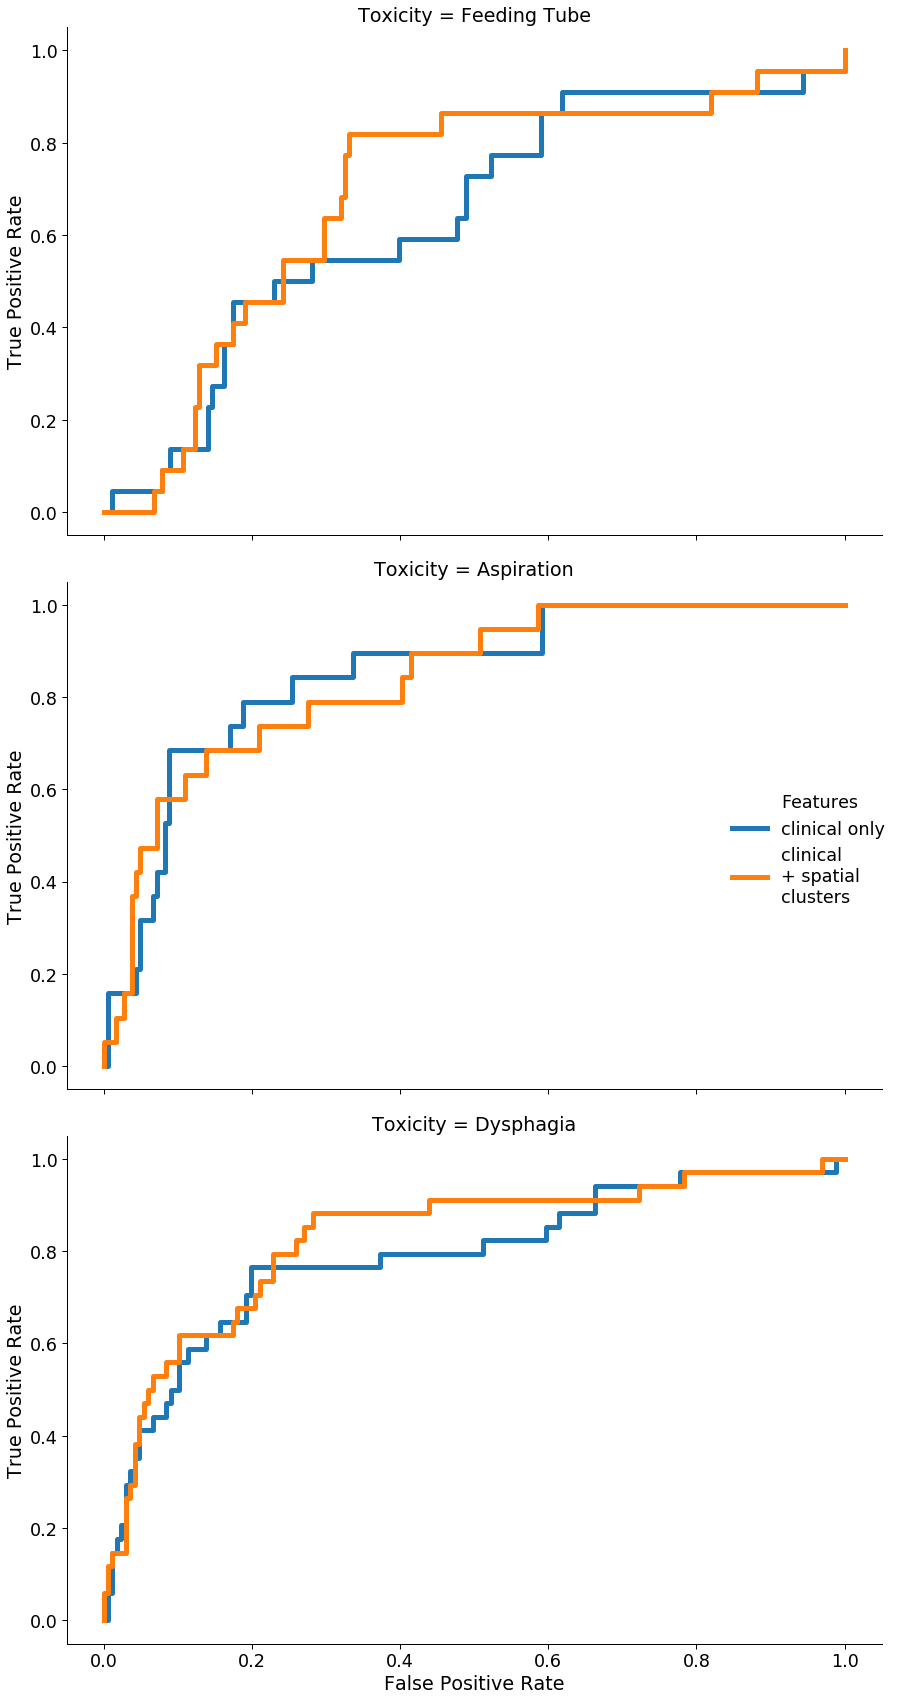

In [46]:

    #commented part makes them all different plots
#     ax = sns.relplot(x='False Positive Rate', y = 'True Positive Rate', 
#                     hue ='Toxicity',
#                     style = 'Features',
#                     data = curves, 
#                     kind='line',
#                     height = fig_height,
#                     aspect = aspect,
#                     estimator = None)
layout_figure(linewidth = 5)
plt.suptitle('ROC Curves')
ax = sns.relplot(x='False Positive Rate', y = 'True Positive Rate', 
                hue ='Features',
                row = 'Toxicity',
                data = curves, 
                kind='line',
                 height = 8,
                 aspect = 1.3,
                 legend = 'brief',
                estimator = None)
plt.tight_layout()

In [178]:
#maybe no use this?
# features_to_drop = []
# temp_scores = []
# spatial = spatial_features.drop(['cluster_labels'], axis = 1)
# best_clusterer = BestClusterer(min_clusters = 2, max_clusters = 5)
# for feature in spatial.columns[::-1]:
#     x = spatial.drop(features_to_drop, axis = 1).values
#     clusters = best_clusterer.fit_predict(x,db.toxicity)
#     temp_scores.append(fisher_exact_test(clusters, db.toxicity))
#     features_to_drop.append(feature)
# plt.plot(np.arange(len(temp_scores)), np.log(1/np.array(temp_scores)[::-1]))

In [179]:
test_range = np.arange(1, 150)
n_subsamples = 500

def get_valid_id_subset(n_to_remove, outcome = 'toxicity', min_value = 2):
    data = db.to_dataframe([outcome])
    dsize = data.shape[0] - n_to_remove
    ids_to_keep = np.random.choice(data.index.values, dsize, replace = False)
    while data.loc[ids_to_keep].sum().values < min_value:
        ids_to_keep = np.random.choice(data.index.values, dsize, replace = False)
    return ids_to_keep

def auc_subset_scores(clusterer, n_subsamples = n_subsamples, test_range = test_range):
    auc_subset_scores = np.zeros((n_subsamples, len(test_range)))
    for pos, n_to_remove in enumerate(test_range):
        subsample_count = np.min([n_subsamples, n_to_remove*db.get_num_patients()])
        for n in range(n_subsamples):
            ids_to_keep = get_valid_id_subset( n_to_remove)
#             ids_to_keep = np.random.choice(db.ids, (db.get_num_patients() - n_to_remove,), replace = False) 
            _, _, auc_score = get_subset_roc(ids_to_keep, clusterer = clusterer)
            auc_subset_scores[n, pos] = auc_score
        print(auc_subset_scores[:,pos].mean())
    sensitivity = pd.DataFrame(auc_subset_scores, columns = test_range)
    return sensitivity

In [278]:
def get_analysis(filename, clusterer):
    try:
        sensitivity = pd.read_csv(filename)
    except:
        print('error reading ' + filename)
        sensitivity = auc_subset_scores(clusterer)
        try:
            sensitivity.to_csv(filename, index = False)
            print('saved to ' + filename)
        except:
            print('could not save file for some reason')
    print(sensitivity.describe())
    return sensitivity
cluster_file = 'data/sensitivity_analysis_clusters_novolume.csv'
sensitivity_clusters = get_analysis(cluster_file, default_clusterer())

error reading data/sensitivity_analysis_clusters_novolume.csv
0.8287107445826084
0.8267534090754328
0.8231407755734087
0.8205778086496478
0.8186944817348633
0.8171561530666579
0.8148558940193918
0.812615156591497
0.814614202161711
0.8085445226347149
0.8103720674316048
0.809386395110434
0.8055214710573508
0.8066775432756423
0.803926313165947
0.8046571289177177
0.8027657078701139
0.8065039473890624
0.8022565844577905
0.8028062987374562
0.8020024016098709
0.8018514219524181
0.7996728507999706
0.7994215266338529
0.797803817850214
0.7967897933818489
0.7971452087381967
0.7969495350610837
0.7994581767927866
0.7981668373511921
0.794498457388385
0.7966251653862227
0.7933950515865188
0.7933966974027349
0.7953966039353473
0.7912073556596867
0.7938038736445278
0.7940014639297756
0.7974474526575521
0.7905018702864443
0.7923000633844883
0.7912649337220312
0.7890647658915632
0.7942351671013439
0.7948010873407007
0.7907355063613625
0.7892946065051278
0.791261910438602
0.788994070210018
0.7893432619167

In [181]:
nocluster_file = 'data/sensitivity_analysis_noclusters.csv'
sensitivity_no_clusters = get_analysis(nocluster_file, None)

                1           2           3           4           5           6  \
count  500.000000  500.000000  500.000000  500.000000  500.000000  500.000000   
mean     0.785314    0.784618    0.784817    0.784021    0.783816    0.783929   
std      0.004710    0.006388    0.008352    0.008817    0.010102    0.011842   
min      0.775465    0.764495    0.763636    0.761242    0.761998    0.754799   
25%      0.784135    0.782640    0.781306    0.779513    0.777984    0.776612   
50%      0.784848    0.784075    0.783733    0.783004    0.782974    0.782569   
75%      0.785918    0.786227    0.786945    0.787328    0.788107    0.789015   
max      0.818364    0.826619    0.840341    0.823265    0.832822    0.844647   

                7           8           9          10  ...         140  \
count  500.000000  500.000000  500.000000  500.000000  ...  500.000000   
mean     0.782968    0.783367    0.783646    0.782565  ...    0.698092   
std      0.012030    0.013858    0.015747    0.0

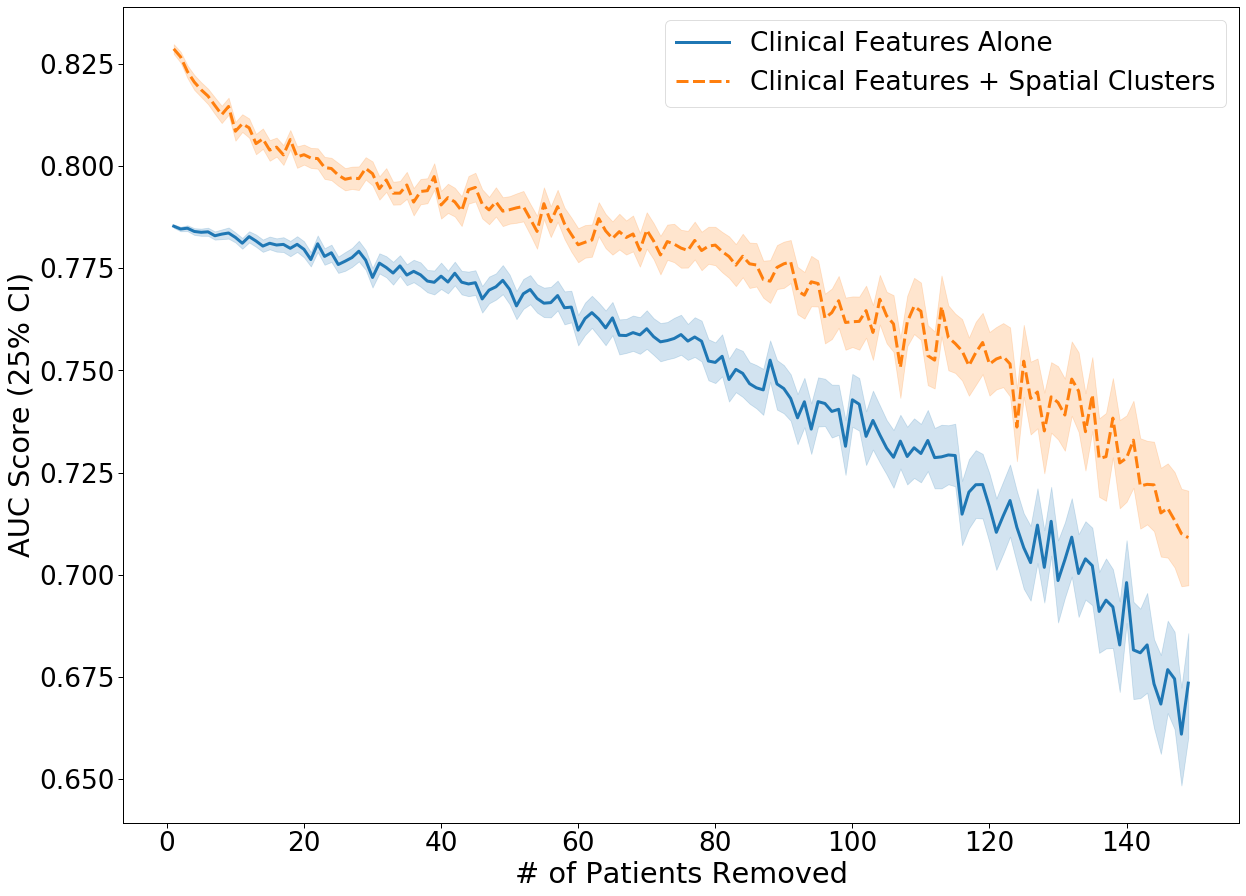

In [280]:
def format_data(report,  max_x = None, min_x = 0):
    report_cols = ['number_removed', 'auc']
    n_steps = np.min([report.shape[1], max_x]) - min_x
    report_data = np.zeros((report.shape[0]*n_steps, 2))
    pos = 0
    for x, r in enumerate(report.T.itertuples()):
        if x < min_x:
            continue
        if max_x is not None and x >= max_x:
            break
        n_patients = r[0]
        for t in r[1:]:
            report_data[pos,:] = [n_patients, t]
            pos += 1
    data = pd.DataFrame(report_data, columns = report_cols)
    return data

def plot_report(report_list, names, max_x = None):
    reports = [format_data(report, max_x) for report in report_list]
    final_report = []
    for report, name in zip(reports, names):
        report['group'] = np.full((report.shape[0],), name)
        final_report.append(report)
    data = pd.concat(final_report, ignore_index = True)
    layout_figure(linewidth = 3, width = 20, height = 15, fontsize = 3)
    fig = sns.lineplot(x='number_removed',y='auc', hue='group',style = 'group', data=data)
    plt.legend(labels = ['Clinical Features Alone', 'Clinical Features + Spatial Clusters'])
    plt.xlabel('# of Patients Removed')
    plt.ylabel('AUC Score (25% CI)')
    
plot_report([sensitivity_no_clusters, sensitivity_clusters], ['no_clusters', 'clusters'], len(test_range))

In [291]:
auc_diff = (sensitivity_clusters.mean().values - sensitivity_no_clusters.mean().values)
print(auc_diff)
print(auc_diff.mean())
print(auc_diff[148])

[0.04339679 0.04213499 0.03832415 0.03655724 0.03487888 0.03322695
 0.03188838 0.02924788 0.03096832 0.02597953 0.02922595 0.02662864
 0.02383437 0.02623324 0.02279801 0.02395272 0.02191158 0.02660848
 0.02138696 0.0231585  0.02485381 0.02084526 0.02176285 0.02061401
 0.02187464 0.02005067 0.01951645 0.01776797 0.02245728 0.02540889
 0.01822921 0.0214222  0.01955476 0.01780555 0.02204495 0.01694632
 0.02039721 0.02212113 0.02586743 0.01742038 0.02065829 0.01746887
 0.01745816 0.02306305 0.02331715 0.02322915 0.01962296 0.02078779
 0.01693499 0.01949469 0.02399964 0.0213576  0.01732058 0.0163993
 0.02435448 0.01978782 0.0217717  0.02057441 0.01779595 0.02089671
 0.01866406 0.01777067 0.024592   0.02377195 0.01943352 0.02536799
 0.02400137 0.02414167 0.02073204 0.02415635 0.02342721 0.02126298
 0.0242311  0.02309899 0.02116755 0.02217158 0.02363607 0.02217548
 0.02811834 0.02870417 0.02563329 0.03011516 0.02550825 0.02866
 0.02933306 0.0300616  0.02701937 0.01931997 0.02851669 0.03053235

In [184]:
from sklearn.utils import resample

def get_feature_auc(feature_df = None, outcome_name = 'toxicity', patient_ids = db.ids,
                           classifier = None, cluster = False):
    #pass it an outcome name (feeding_tubes, aspiration, toxicity)
    #and a list of patient ids to use (like for resampling)
    #and a clusterer function and returns the auc curve score from clusters on the spatial
    #feature clusters + clinical features
    if classifier is None:
        classifier = LogisticRegression(solver='lbfgs', max_iter=8000)
    clinical = clinical_features.loc[patient_ids]
    outcomes = db.to_dataframe([outcome_name])
    outcomes = outcomes.loc[patient_ids]
    if feature_df is not None:
        features = feature_df.loc[patient_ids]
        if cluster:
            fvalues = features.values
            if fvalues.ndim < 2:
                fvalues = fvalues.reshape(-1,1)
            clusters = default_clusterer().fit_predict(fvalues)
            clusters = pd.get_dummies(clusters)
            clusters.index = features.index
            features = clusters
        elif isinstance(features, pd.Series):
            features = pd.DataFrame(features)
        clinical = clinical.sort_index()
        features = features.sort_index()
        outcomes = outcomes.sort_index()
        for f in features.columns:
            clinical[f] = features[f].values
    probs = loo_cross_val_proba(classifier, clinical, outcomes,
                               transformer = QuantileTransformer(n_quantiles = len(patient_ids) - 1)
                               )

    auc_score = roc_auc_score(outcomes.values, probs)
    return auc_score

def get_extra_features(dose_organs = ['Mandible', 'Rt_Ant_Digastric_M', 'Lt_Ant_Digastric_M'], 
                       volume_organs = ['Rt_Sternocleidomastoid_M','Lt_Sternocleidomastoid_M', 'Rt_Masseter_M', 'Lt_Masseter_M'], 
                       idx_name = 'Dummy.ID'):
    features = db.to_dataframe(['doses'], organ_list = dose_organs, merge_mirrored_organs = True)
    features = db.to_dataframe(['volumes'], 
                               organ_list = volume_organs, 
                               merge_mirrored_organs = True, 
                               to_merge = features)
    if idx_name is not None:
        features.index = features.index.rename(idx_name)
    return features

def get_features_to_isolate():
    features = get_extra_features()
    features = Metrics.normalize(features)
    features = features.merge(spatial_features.drop('cluster_labels',axis=1), on = ['Dummy.ID'])
    return features

def boostrapped_auc_increase(n_samples = 1):
    features = get_features_to_isolate()
    feature_scores =[]
    for n in range(n_samples):
        print(100*n/n_samples, '% done')
        if n_samples > 1:
            ids = resample(db.ids, stratify = db.toxicity)
        else:
            ids = np.copy(db.ids)
            np.random.shuffle(ids) #I added this for debugging and will keep it in.  Makes sure we know it works with n=1 even if order is changed
        baseline = get_feature_auc(patient_ids = ids)
        print(baseline)
        goodest_auc = get_feature_auc(spatial_features.drop('cluster_labels',axis=1), 
                                      patient_ids = ids, cluster = True)
        feature_scores.append(['Spatial Features', goodest_auc - baseline])
        for fname in features.columns:
            score = get_feature_auc(features[fname], 
                                    patient_ids = ids, 
                                    cluster = False)
            feature_scores.append([fname, score - baseline])
        print(goodest_auc)
    return pd.DataFrame(feature_scores, columns= ['Feature','AUC'])



In [185]:
def get_split_auc(train_ids, test_ids, feature_df = None, outcome_name = 'toxicity', classifier = None, cluster = False):
    #pass it an outcome name (feeding_tubes, aspiration, toxicity)
    #and a list of patient ids to use (like for resampling)
    #and a clusterer function and returns the auc curve score from clusters on the spatial
    #feature clusters + clinical features
    if classifier is None:
        classifier = LogisticRegression(solver='lbfgs', max_iter=8000)
    clinical = clinical_features.copy()
    outcomes = db.to_dataframe([outcome_name])
    outcomes = outcomes.copy()
    if feature_df is not None:
        features = feature_df.copy()
        if cluster:
            fvalues = features.values
            if fvalues.ndim < 2:
                fvalues = fvalues.reshape(-1,1)
            clusters = default_clusterer().fit_predict(fvalues)
            clusters = pd.get_dummies(clusters)
            clusters.index = features.index
            features = clusters
        elif isinstance(features, pd.Series):
            features = pd.DataFrame(features)
        for f in features.columns:
            clinical[f] = features[f].values
    xtrain =clinical.loc[train_ids].values
    xtest = clinical.loc[test_ids].values
    ytrain = outcomes.loc[train_ids].values
    ytest = outcomes.loc[test_ids].values
    classifier.fit(xtrain, ytrain.ravel())
    ypred = classifier.predict_proba(xtest)[:,1]

    auc_score = roc_auc_score(ytest, ypred)
    return auc_score

def random_sample_auc_increase(n_splits = 100, split_size = .25, outcome = 'toxicity'):
    features = get_features_to_isolate()
    tox = db.to_dataframe([outcome])
    spatial = spatial_features.drop('cluster_labels',axis=1)
    feature_scores =[]
    for n in range(n_splits):
        print(100*n/n_splits, '% done')
        train_ids, test_ids = get_id_split(features, tox, split_size)
        baseline = get_split_auc(train_ids, test_ids)
        goodest_auc = get_split_auc(train_ids, test_ids,
                                    spatial, 
                                    cluster = True)
        print(goodest_auc - baseline)
        feature_scores.append(['Spatial Features', goodest_auc - baseline])
        for fname in features.columns:
            score = get_split_auc(train_ids, test_ids,
                                  features[fname], 
                                  cluster = False)
            feature_scores.append([fname, score - baseline ])
    return pd.DataFrame(feature_scores, columns= ['Feature','AUC'])

        
def get_id_split(x_df, y_df, split_size):
    split_loc = int(x_df.shape[0]*split_size)+1
    while True:
        ids = np.copy(db.ids)
        np.random.shuffle(ids)
        test_ids = ids[:split_loc]
        train_ids = ids[split_loc:]

        ytrain = y_df.loc[train_ids].values
        ytest = x_df.loc[test_ids].values
        if ytrain.sum() > 2 and ytest.sum() > 2:
            break
    return train_ids, test_ids
        

In [187]:
from matplotlib.ticker import MultipleLocator

fname_dict = {
    'Ant_Digastric_M_doses_combined': 'Anterior\nDigastric\nTrue Dose (Gy)',
    'Extended_Oral_Cavity_tsimdoses': 'Extended\nOral Cavity\nPredicted\nDose(Gy)',
    'MPC_tumor_distances': 'MPC-Tumor\nDistance (mm)',
    'Mandible_doses': 'Mandible\nTrue Dose (Gy)',
    'Mandible_tsimdoses': 'Mandible\nPredicted\nDose (Gy)',
    'Mandible_tumor_distances': 'Mandible-Tumor\nDistance (mm)',
    'Masseter_M_volumes_combined': 'Massester\nVolume (cc)',
    'Medial_Pterygoid_M_tsimdoses_combined': 'Medial\nPterygoid\nPredicted\nDose (Gy)',
    'Spatial Features': '5 Spatial\nClusters',
    'Sternocleidomastoid_M_volumes_combined': 'Sternocleidomastoid\nVolume (cc)',
    't_volumes_0': 'Total Tumor\nVolume'
}

def plot_feature_importances(nsamples):
    if nsamples > 1:
        fdata = random_sample_auc_increase(nsamples)
    else:
        fdata = boostrapped_auc_increase(1)
    try:
        fdata.to_csv('data/feature_importances_test_n=' + str(nsamples) + '.csv')
    except:
        print('error saving file')
    if nsamples > 1:
        plot_fi(fdata, 'violin')
    else:
        plot_fi(fdata)
    return fdata

def plot_fi(data, type = 'bar'):
    layout_figure(linewidth = 3, width = 40, height = 20, fontsize = 3)
    with sns.axes_style(rc = {'axes.grid':True,
                              'grid.color': '0.1',
                             }):
        data = data.replace(fname_dict)
        if type == 'bar':
            data = data.groupby(['Feature']).mean().sort_values(['AUC'], ascending = False).reset_index()
            ax = sns.barplot(x = 'Feature',y = 'AUC', data = data, orient='v')
            ax.yaxis.set_major_locator(MultipleLocator(.01))
        else:
            ax = sns.violinplot(x = 'Feature', y = 'AUC', 
                                    data = data, orient='v', 
                                    showfliers=False)
            ax.yaxis.set_major_locator(MultipleLocator(.03))
        plt.ylabel('AUC Score Increase')
        plt.xticks(rotation = 15)
        plt.xlabel('')
        plt.title('AUC Score Increase After Addition of Individidual Features')

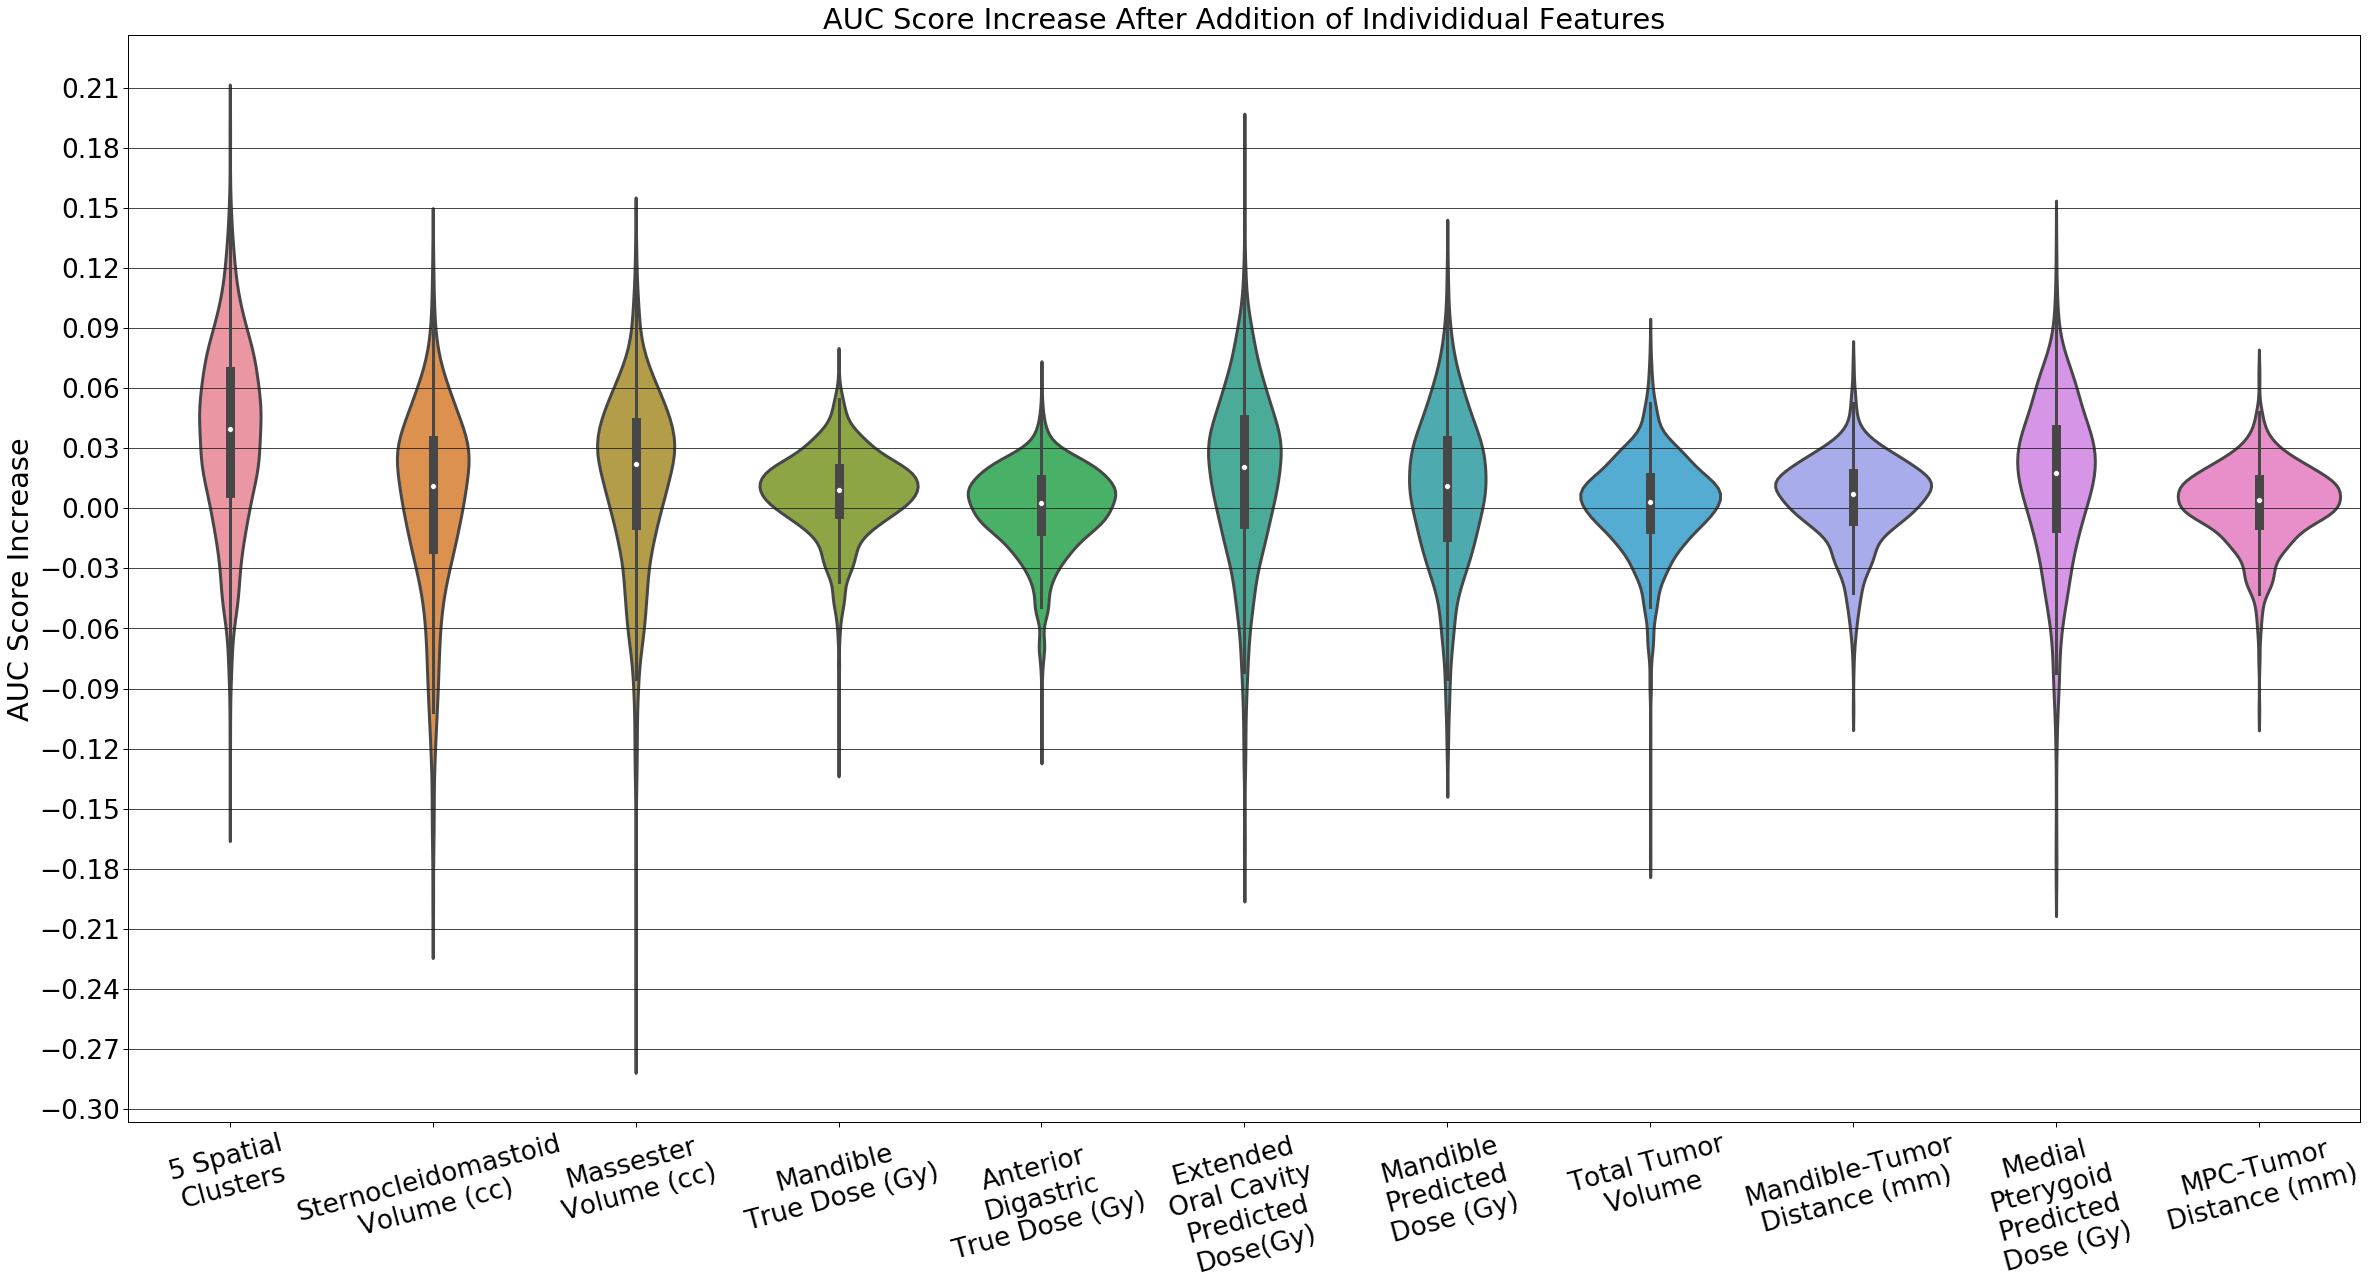

In [135]:
# big_samples = random_sample_auc_increase(1000)
# plot_fi(big_samples, 'violin')

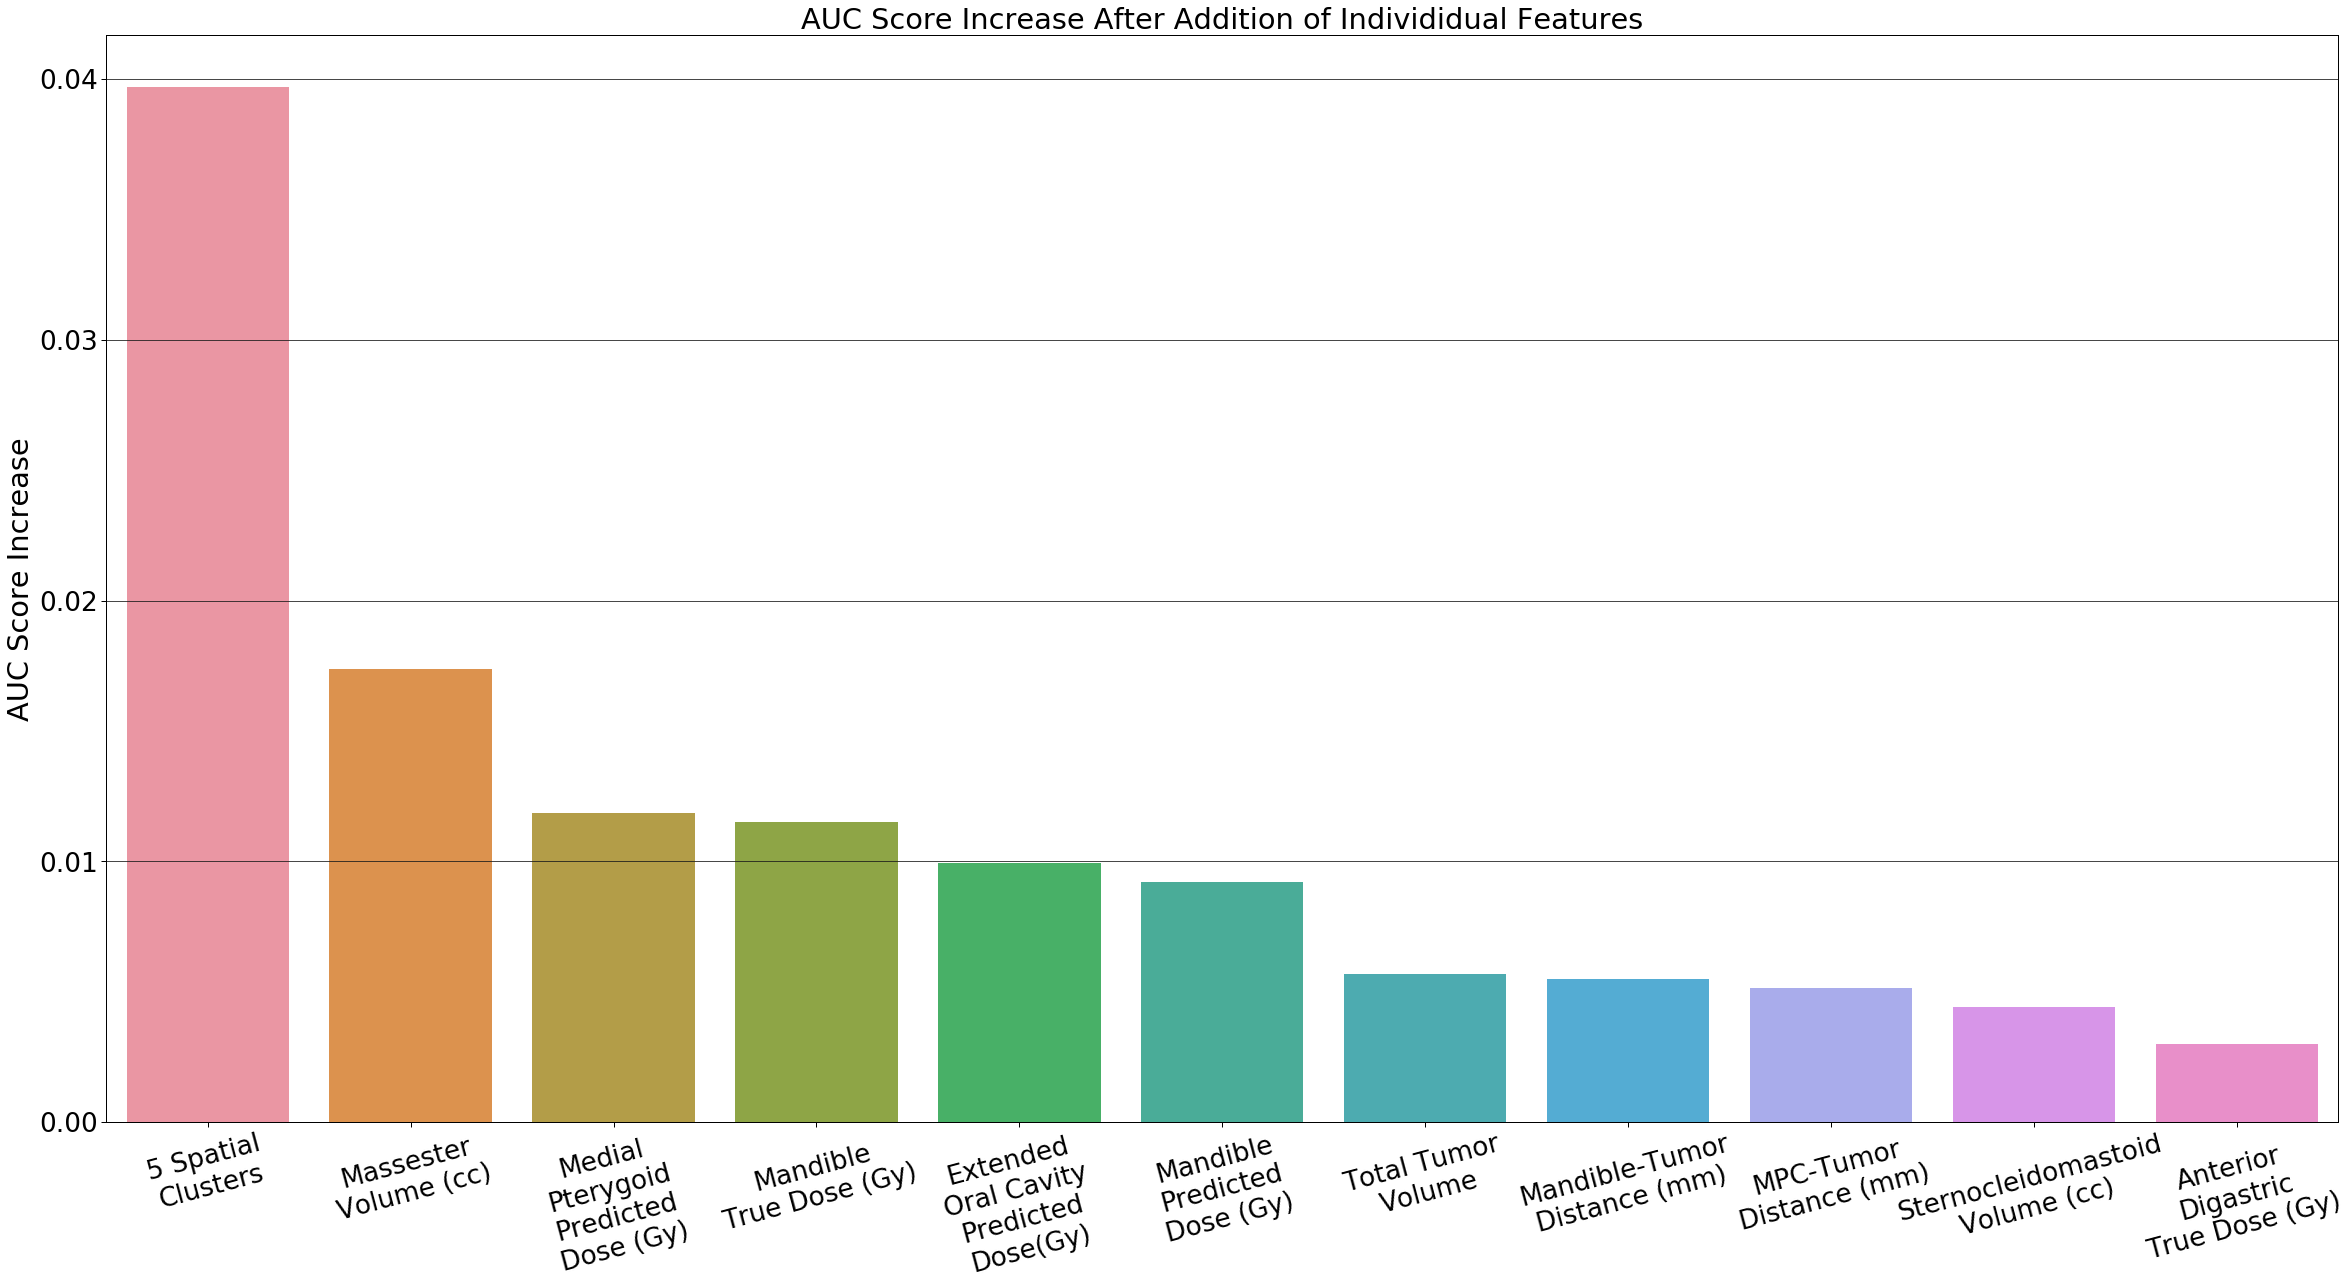

In [127]:
# fdata = boostrapped_auc_increase(1)
# plot_fi(fdata, 'bar')

In [188]:
fdata

,Feature,AUC
0,Spatial Features,0.039688
1,Sternocleidomastoid_M_volumes_combined,0.004429
2,Masseter_M_volumes_combined,0.017364
3,Mandible_doses,0.011517
4,Ant_Digastric_M_doses_combined,0.003012
5,Extended_Oral_Cavity_tsimdoses,0.009922
6,Mandible_tsimdoses,0.009213
7,t_volumes_0,0.005670
8,Mandible_tumor_distances,0.005493
9,Medial_Pterygoid_M_tsimdoses_combined,0.011871


In [237]:
db.t_categories_imputed = np.zeros(db.t_categories.shape)
for p, val in enumerate(db.t_categories):
    if val not in ['T1', 'T2', 'T3', 'T4']:
        db.t_categories_imputed[p] = 1
    else:
        db.t_categories_imputed[p] = int(val[1])
db.t_categories_imputed

array([2., 1., 3., 3., 2., 2., 1., 1., 2., 3., 1., 4., 2., 2., 2., 4., 2.,
       2., 3., 1., 1., 3., 2., 2., 1., 1., 1., 1., 2., 3., 2., 2., 1., 3.,
       3., 1., 2., 2., 2., 1., 2., 2., 2., 1., 3., 1., 2., 2., 3., 2., 2.,
       3., 1., 3., 3., 1., 4., 4., 2., 2., 2., 3., 2., 1., 3., 2., 1., 1.,
       2., 1., 1., 3., 3., 2., 1., 2., 1., 1., 3., 1., 2., 3., 2., 1., 1.,
       1., 1., 3., 4., 2., 1., 1., 2., 2., 2., 4., 1., 1., 3., 2., 2., 2.,
       2., 2., 1., 1., 2., 4., 2., 2., 1., 4., 2., 1., 2., 2., 1., 1., 1.,
       2., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 3., 1., 2., 1., 2., 2.,
       2., 4., 3., 1., 2., 1., 3., 1., 3., 4., 2., 3., 2., 2., 2., 3., 4.,
       3., 3., 2., 4., 3., 2., 1., 2., 1., 1., 1., 2., 3., 2., 4., 2., 3.,
       2., 2., 3., 1., 3., 2., 2., 2., 2., 2., 2., 3., 3., 3., 2., 4., 3.,
       2., 3., 2., 3., 4., 3., 4., 1., 4., 4., 1., 3., 3.])

In [193]:
clinical_features.sum()

Age.at.Diagnosis..Calculated.                                 100.032186
Total.dose                                                    141.858333
Pathological.Grade_II                                          53.000000
Pathological.Grade_III                                        105.000000
Pathological.Grade_IV                                           2.000000
Pathological.Grade_I                                            1.000000
Therapeutic.combination_CC                                    115.000000
Therapeutic.combination_Radiation.alone                        22.000000
Therapeutic.combination_IC.CC                                  42.000000
Therapeutic.combination_IC.Radiation.alone                     21.000000
Tm.Laterality..R.L._L                                          93.000000
Tm.Laterality..R.L._R                                         111.000000
HPV.P16.status_Positive                                       130.000000
HPV.P16.status_Negative                            

In [242]:
clinical_feature_names = ['ages','prescribed_doses','pathological_grades',
                          'therapy_type','lateralities','hpv',
                         'smoking','subsites']

cf = db.to_dataframe(clinical_feature_names)
clinical_clusters2 = FClusterer(4, dist_func = l1).fit_predict(cf.values)
print(fisher_exact_test(clinical_clusters2.ravel(), db.toxicity))
print(fisher_exact_test(clinical_clusters['manhattan_k=4'].values, db.toxicity))
print(fisher_exact_test(db.t_categories_imputed, db.toxicity))
print(fisher_exact_test(db.ajcc8, db.toxicity))

0.0030410636911788356
2.029504287547485e-05
2.097329008403267e-09
0.0023751881933333162


In [249]:
#scores for just t category for classification
for tox in ['feeding_tubes', 'aspiration', 'toxicity']:
    ypred = loo_cross_val_proba(lg, db.to_dataframe(['t_categories_imputed']).values, getattr(db, tox))
    print(tox, roc_auc_score(getattr(db, tox), ypred))

feeding_tubes 0.6016343207354443
aspiration 0.7621401570223902
toxicity 0.6959603118355776


In [261]:
#scores for just t category alongside clusters for classification
sfc = pd.DataFrame(spatial_feature_clusters(), index = db.ids)
for tox in ['feeding_tubes', 'aspiration', 'toxicity']:
    y = getattr(db, tox)
    x = db.to_dataframe(['t_categories_imputed'], to_merge = sfc).values
    ypred = loo_cross_val_proba(lg, x, y)
    print(tox, roc_auc_score(y, ypred))

feeding_tubes 0.6613891726251278
aspiration 0.8246583309101483
toxicity 0.7877391920623671


In [269]:
((db.t_categories == 'T4').astype(int)*db.aspiration).sum()

10.0

In [270]:
10/18

0.5555555555555556

In [321]:
from analysis import *
from Metrics import *
new_db = copy.copy(db)
new_db.classes = spatial_feature_clusters(FClusterer(5, dist_func = l2), drop = [])
spatial_feature_clusters()

array([1, 1, 3, 3, 3, 1, 1, 0, 1, 1, 1, 3, 1, 3, 3, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 3, 1, 3, 1, 1, 3, 2, 1, 1, 1, 3, 1, 3, 3, 3, 0, 3,
       1, 1, 1, 1, 3, 1, 1, 1, 1, 0, 0, 1, 0, 3, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 3, 0, 0, 1, 3, 1, 1, 3, 1, 1, 1, 0, 1, 1, 3, 3, 3, 1,
       0, 0, 3, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       1, 0, 3, 1, 1, 1, 1, 1, 3, 1, 3, 1, 3, 1, 0, 1, 0, 1, 1, 3, 3, 1,
       3, 1, 1, 1, 0, 1, 0, 1, 0, 3, 0, 1, 0, 3, 1, 0, 1, 2, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 3, 1, 3, 0, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 3, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 2], dtype=int32)

In [322]:
method = {'predicted_doses': db.tsimdoses}

In [323]:
class_sim = augmented_sim(db.classes, lambda x,y: x == y)
cluster_sim = augmented_sim(spatial_features.drop('cluster_labels', axis = 1).values, lambda x,y: 1/(1+np.linalg.norm(x-y)))
method['similarity'] = cluster_sim

In [324]:
export(new_db, method = method)

error:  0.1650500289545297 %
using augmented similarities
successfully save patient data to  ../data/patient_dataset.json
successfully saved similarity score matrix to  data/scores.csv


In [314]:
spatial_features.columns

Index(['Extended_Oral_Cavity_tsimdoses', 'Mandible_tsimdoses', 't_volumes_0',
       'Mandible_tumor_distances', 'Medial_Pterygoid_M_tsimdoses_combined',
       'MPC_tumor_distances', 'cluster_labels'],
      dtype='object')